In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import seaborn as sns
import random
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers

In [2]:
#load facial keypoints data
keyfacial_df = pd.read_csv('data.csv')
keyfacial_df.head()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   
1          64.332936          34.970077           29.949277   
2          65.057053          34.909642           30.903789   
3          65.225739          37.261774           32.023096   
4          66.725301          39.621261           32.244810   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   
1           33.448715                58.856170                35.274349   
2           34.909642                59.412000                36.320968   
3           37.261774                60.003339                39.127179   
4           38.042032                58.565890                39.621261   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   
1                70.722723                36.187166                 36.034723   
2                70.984421                36.320968                 37.678105   
3                72.314713                38.380967                 37.618643   
4                72.515926                39.884466                 36.982380   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 37.389402  ...   57.066803            61.195308   
1                 34.361532  ...   55.660936            56.421447   
2                 36.320968  ...   53.538947            60.822947   
3                 38.754115  ...   54.166539            65.598887   
4                 39.094852  ...   64.889521            60.671411   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            79.970165             28.614496             77.388992   
1            76.352000             35.122383             76.047660   
2            73.014316             33.726316             72.732000   
3            72.703722             37.245496             74.195478   
4            77.523239             31.191755             76.997301   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               43.312602               72.935459                  43.130707   
1               46.684596               70.266553                  45.467915   
2               47.274947               70.191789                  47.274947   
3               50.303165               70.091687                  51.561183   
4               44.962748               73.707387                  44.227141   

   mouth_center_bottom_lip_y  \
0                  84.485774   
1                  85.480170   
2                  78.659368   
3                  78.268383   
4                  86.871166   

                                               Image  
0  238 236 237 238 240 240 239 241 241 243 240 23...  
1  219 215 204 196 204 211 212 200 180 168 178 19...  
2  144 142 159 180 188 188 184 180 167 132 84 59 ...  
3  193 192 193 194 194 194 193 192 168 111 50 12 ...  
4  147 148 160 196 215 214 216 217 219 220 206 18...  

[5 rows x 31 columns]

In [3]:
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [4]:
keyfacial_df.isnull().sum().sum()

0

In [5]:
keyfacial_df['Image'].shape

(2140,)

In [6]:
#since values for the image are given as space separated string, separate the values using ' ' as separator
#Then convert this into numpy array using np.fromstring and convert the obtained 1D array int 2D array of shape (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [7]:
#shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

In [8]:
keyfacial_df.describe()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
count        2140.000000        2140.000000         2140.000000   
mean           66.221549          36.842274           29.640269   
std             2.087683           2.294027            2.051575   
min            47.835757          23.832996           18.922611   
25%            65.046300          35.468842           28.472224   
50%            66.129065          36.913319           29.655440   
75%            67.332093          38.286438           30.858673   
max            78.013082          46.132421           42.495172   

       right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
count         2140.000000              2140.000000              2140.000000   
mean            37.063815                59.272128                37.856014   
std              2.234334                 2.005631                 2.034500   
min             24.773072                41.779381                27.190098   
25%             35.818377                58.113054                36.607950   
50%             37.048085                59.327154                37.845220   
75%             38.333884                60.521492                39.195431   
max             45.980981                69.023030                47.190316   

       left_eye_outer_corner_x  left_eye_outer_corner_y  \
count              2140.000000              2140.000000   
mean                 73.412473                37.640110   
std                   2.701639                 2.684162   
min                  52.947144                26.250023   
25%                  71.741978                36.102409   
50%                  73.240045                37.624207   
75%                  74.978684                39.308331   
max                  87.032252                49.653825   

       right_eye_inner_corner_x  right_eye_inner_corner_y  ...   nose_tip_x  \
count               2140.000000               2140.000000  ...  2140.000000   
mean                  36.603107                 37.920852  ...    47.952141   
std                    1.822784                  2.009505  ...     3.276053   
min                   24.112624                 26.250023  ...    24.472590   
25%                   35.495730                 36.766783  ...    46.495330   
50%                   36.620735                 37.920336  ...    47.900511   
75%                   37.665280                 39.143921  ...    49.260657   
max                   47.293746                 44.887301  ...    65.279654   

        nose_tip_y  mouth_left_corner_x  mouth_left_corner_y  \
count  2140.000000          2140.000000          2140.000000   
mean     57.253926            63.419076            75.887660   
std       4.528635             3.650131             4.438565   
min      41.558400            43.869480            57.023258   
25%      54.466000            61.341291            72.874263   
50%      57.638582            63.199057            75.682465   
75%      60.303524            65.302398            78.774969   
max      75.992731            84.767123            94.673637   

       mouth_right_corner_x  mouth_right_corner_y  mouth_center_top_lip_x  \
count           2140.000000           2140.000000             2140.000000   
mean              32.967365             76.134065               48.081325   
std                3.595103              4.259514                2.723274   
min                9.778137             56.690208               32.260312   
25%               30.879288             73.280038               46.580004   
50%               33.034022             75.941985               47.939031   
75%               35.063575             78.884031               49.290000   
max               50.973348             93.443176               61.804506   

       mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
count             2140.000000                2140.000000   
mean                72.681125                  48.149654

# VISUALIZE THE IMAGE

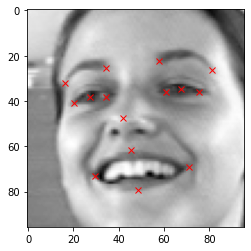

In [9]:
i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
    plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

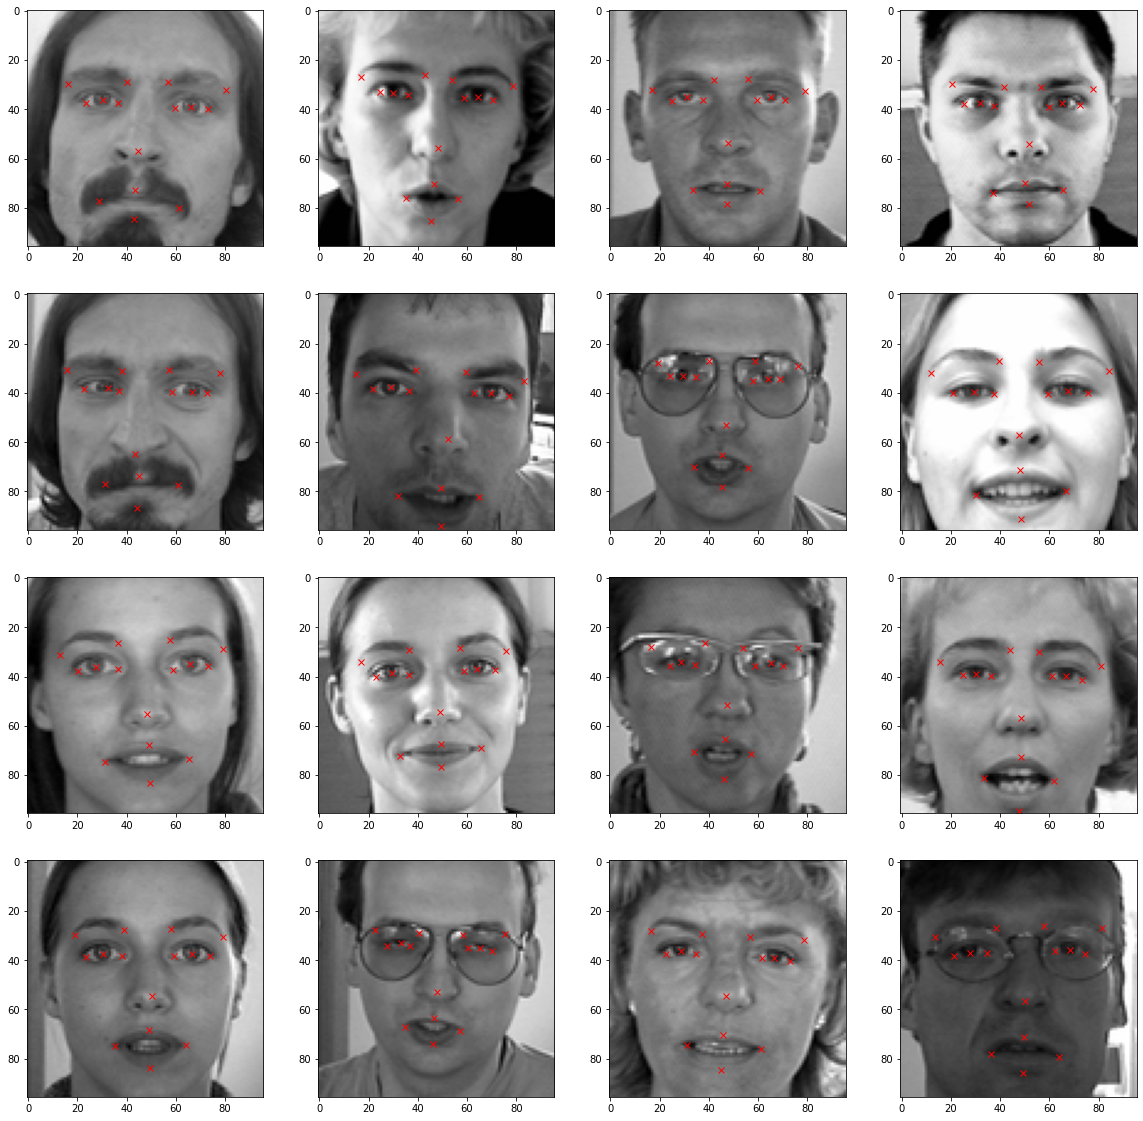

In [10]:
#viewing first 16 images
#viewing on a grid format
fig = plt.figure(figsize = (20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    image = plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
    for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j - 1], keyfacial_df.loc[i][j], 'rx')

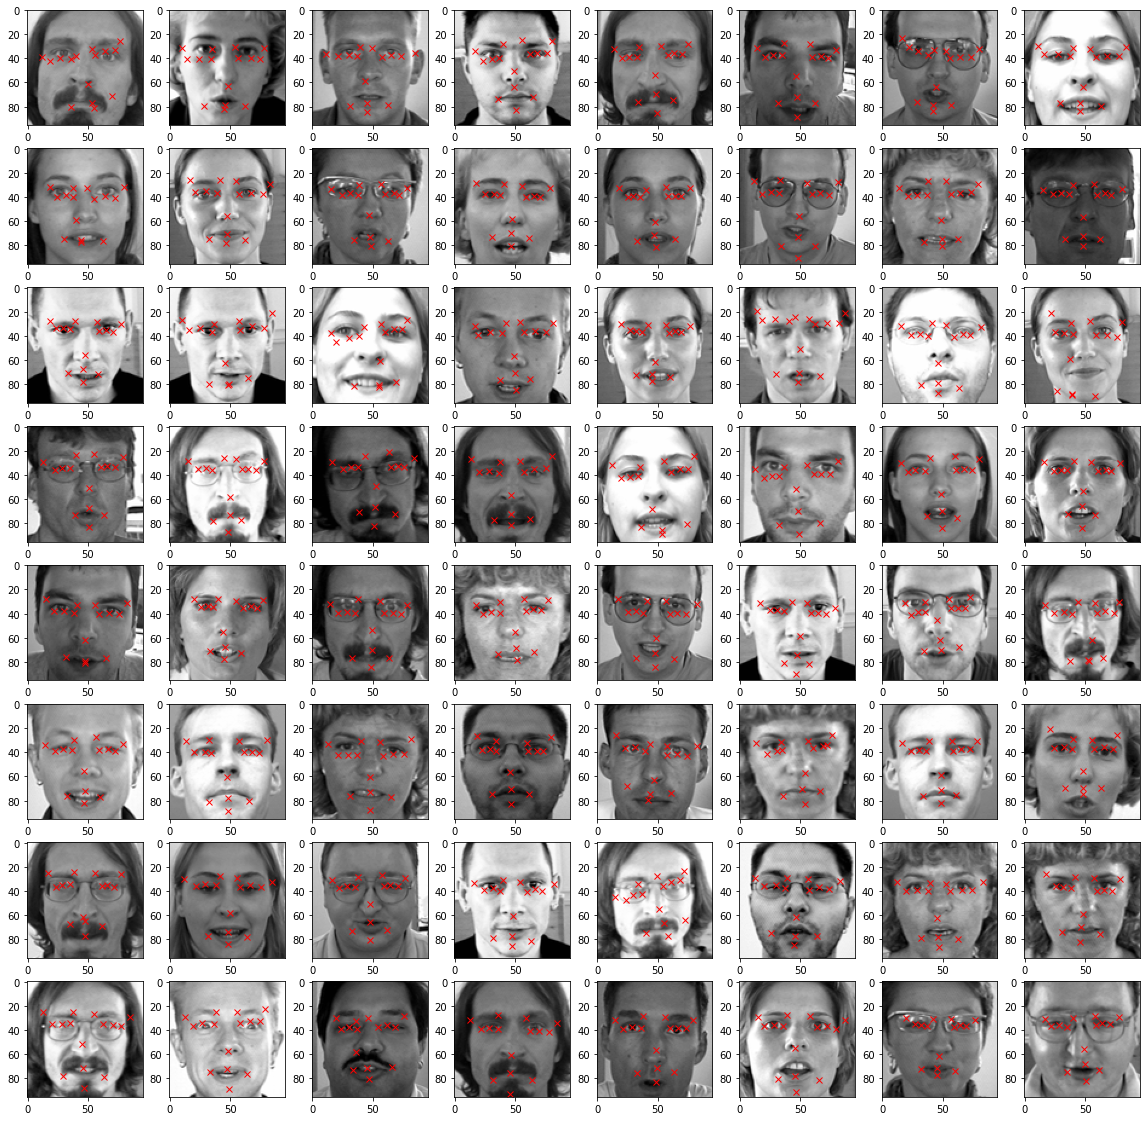

In [11]:
#viewing random images
fig = plt.figure(figsize = (20, 20))

for i in range(64):
    k = random.randint(1, len(keyfacial_df))
    ax = fig.add_subplot(8, 8, i + 1)
    image = plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
    for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[k][j - 1], keyfacial_df.loc[k][j], 'rx')

# IMAGE AUGMENTATION

In [12]:
# create a copy of the dataframe
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [13]:
#Obtain columns in the dataframe
columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [14]:
#Horizontal flip- flip images along y axis
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))
for i in range(len(columns)):
    if 1%2 == 0:
        keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))

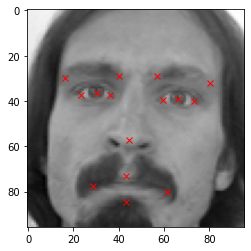

In [15]:
#show the olriginal mage
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
    plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

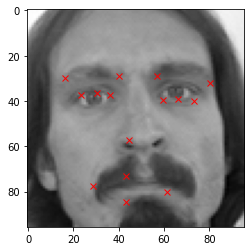

In [16]:
#show the flipped mage
plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
    plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [17]:
#Concatenate the original dataframe with augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))
augmented_df.shape

(4280, 31)

In [18]:
#Increasing brightness of images by multiplying pixel values between 1.5 and 2
import random

keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)*x, 0.0, 255.0))
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

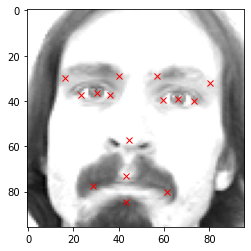

In [19]:
#show the icreased brightness
plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
    plt.plot(keyfacial_df_copy.loc[0][j - 1], keyfacial_df_copy.loc[0][j], 'rx')

In [20]:
keyfacial_df_copy = copy.copy(keyfacial_df)

In [21]:
#flipping vertically
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))
for i in range(len(columns)):
    if 1%2 == 1:
        keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))

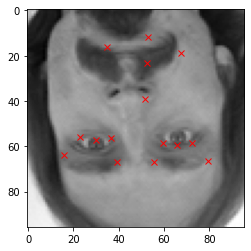

In [22]:
#show the flipped mage
plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
    plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

# DATA NORMALIZATION AND TRAINING DATA PREPARATION

In [23]:
#Obtain the value of images which is present in the 31st column
img = augmented_df[:, 30]

#Normalize the Image
img = img/255.0

#Create an empty array of shape (x, 96, 96, 1) to feed the model
x = np.empty((len(img), 96, 96, 1))

#Iterate through the image list and ad image values to the empty array after expanding itd dimensions from (96, 96) to (96, 96, 1)
for i in range(len(img)):
    x[i,] = np.expand_dims(img[i], axis = 2)

#convert the array type to float 32
    
x = np.asarray(x).astype(np.float32)
x.shape

(6420, 96, 96, 1)

In [24]:
#obtain the values of x and y which are used as target
y = augmented_df[:, :30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

# RESBLOCK ARCHITECTURE

### CONVOLUTION BLOCK AND TWO IDENTITY BLOCKS

In [85]:
def res_block(x, filter, stage):
    
    #Convolutional_block
    x_copy = x
    
    f1, f2, f3 = filter
    
    #Main Path
    x = Conv2D(f1, (1, 1), strides = (1, 1), name = 'res_'+str(stage)+'_conv_a', kernel_initializer = glorot_uniform(seed = 0))(x)
    x = MaxPool2D((2, 2))(x)
    x = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_conv_a')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2, kernel_size = (3, 3), strides = (1, 1), padding = 'same', name = 'res_'+str(stage)+'_conv_b', kernel_initializer = glorot_uniform(seed = 0))(x)
    x = BatchNormalization(axis = 3, name = 'bn_'+str(stage)+'_conv_b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(x)
    x = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(x)
    
    #Short path

    x_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(x_copy)
    x_copy = MaxPool2D((2,2))(x_copy)
    x_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(x_copy)

    #ADD

    x = Add()([x,x_copy])
    x = Activation('relu')(x)
    
    #IDENTITY BLOCK 1

    x_copy = x


  #Main Path
    x = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(x)
    x = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(x)
    x = Activation('relu')(x) 

    x = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(x)
    x = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(x)
    x = Activation('relu')(x) 

    x = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(x)
    x = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(x)
    
    #ADD

    x = Add()([x,x_copy])
    x = Activation('relu')(x)
    
    #Identity Block 2

    x_copy = x


  #Main Path
    x = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(x)
    x = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(x)
    x = Activation('relu')(x) 

    x = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(x)
    x = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(x)
    x = Activation('relu')(x) 

    x = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(x)
    x = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(x)

  #ADD

    x = Add()([x,x_copy])
    x = Activation('relu')(x)

    return x

### FINAL MODEL

In [27]:
input_shape = (96,96,1)

#Input tensor shape
x_input = Input(input_shape)

#Zero-padding

x = ZeroPadding2D((3,3))(x_input)

# 1 - stage

x = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(x)
x = BatchNormalization(axis =3, name = 'bn_conv1')(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3), strides= (2,2))(x)

# 2- stage

x = res_block(x, filter= [64,64,256], stage= 2)

# 3- stage

x = res_block(x, filter= [128,128,512], stage= 3)



#Average Pooling

x = AveragePooling2D((2,2), name = 'Averagea_Pooling')(x)

#Final layer

x = Flatten()(x)
x = Dense(4096, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(2048, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(30, activation = 'relu')(x)

In [28]:
model = Model( inputs= x_input, outputs = x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

# COMPILING AND TRAINING THE DEEP LEARNING MODEL

In [29]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error",optimizer= adam , metrics = ['accuracy'])

In [30]:
#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights_keypoint.hdf5", verbose=1, save_best_only=True)

In [31]:
history = model.fit(x_train, y_train, batch_size = 32, epochs= 500, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/500
172/172 [==============================] - 161s 903ms/step - loss: 508.0449 - accuracy: 0.3379 - val_loss: 708.7531 - val_accuracy: 0.7163

Epoch 00001: val_loss improved from inf to 708.75311, saving model to weights_keypoint.hdf5
Epoch 2/500
172/172 [==============================] - 174s 1s/step - loss: 18.6508 - accuracy: 0.5655 - val_loss: 90.7574 - val_accuracy: 0.7163

Epoch 00002: val_loss improved from 708.75311 to 90.75744, saving model to weights_keypoint.hdf5
Epoch 3/500
172/172 [==============================] - 190s 1s/step - loss: 16.1652 - accuracy: 0.6105 - val_loss: 22.9079 - val_accuracy: 0.7197

Epoch 00003: val_loss improved from 90.75744 to 22.90794, saving model to weights_keypoint.hdf5
Epoch 4/500
172/172 [==============================] - 209s 1s/step - loss: 14.4749 - accuracy: 0.6069 - val_loss: 9.8272 - val_accuracy: 0.7197

Epoch 00004: val_loss improved from 22.90794 to 9.82723, saving model to weights_keypoint.hdf5
Epoch 5/500
172/172 [=======

172/172 [==============================] - 153s 890ms/step - loss: 4.0455 - accuracy: 0.7875 - val_loss: 4.2601 - val_accuracy: 0.7924

Epoch 00038: val_loss improved from 4.36076 to 4.26008, saving model to weights_keypoint.hdf5
Epoch 39/500
172/172 [==============================] - 167s 971ms/step - loss: 3.6991 - accuracy: 0.8101 - val_loss: 6.1755 - val_accuracy: 0.8131

Epoch 00039: val_loss did not improve from 4.26008
Epoch 40/500
172/172 [==============================] - 170s 991ms/step - loss: 4.0988 - accuracy: 0.7874 - val_loss: 4.1480 - val_accuracy: 0.8201

Epoch 00040: val_loss improved from 4.26008 to 4.14803, saving model to weights_keypoint.hdf5
Epoch 41/500
172/172 [==============================] - 163s 950ms/step - loss: 3.8052 - accuracy: 0.8112 - val_loss: 3.7662 - val_accuracy: 0.8131

Epoch 00041: val_loss improved from 4.14803 to 3.76618, saving model to weights_keypoint.hdf5
Epoch 42/500
172/172 [==============================] - 170s 991ms/step - loss: 4.09


Epoch 00077: val_loss did not improve from 3.27319
Epoch 78/500
172/172 [==============================] - 152s 883ms/step - loss: 2.8882 - accuracy: 0.8441 - val_loss: 3.6350 - val_accuracy: 0.8512

Epoch 00078: val_loss did not improve from 3.27319
Epoch 79/500
172/172 [==============================] - 158s 921ms/step - loss: 2.6332 - accuracy: 0.8453 - val_loss: 3.2927 - val_accuracy: 0.8443

Epoch 00079: val_loss did not improve from 3.27319
Epoch 80/500
172/172 [==============================] - 152s 881ms/step - loss: 2.6032 - accuracy: 0.8386 - val_loss: 4.7380 - val_accuracy: 0.8443

Epoch 00080: val_loss did not improve from 3.27319
Epoch 81/500
172/172 [==============================] - 154s 896ms/step - loss: 3.1737 - accuracy: 0.8408 - val_loss: 4.7220 - val_accuracy: 0.8581

Epoch 00081: val_loss did not improve from 3.27319
Epoch 82/500
172/172 [==============================] - 154s 893ms/step - loss: 2.8874 - accuracy: 0.8429 - val_loss: 4.2892 - val_accuracy: 0.8547


172/172 [==============================] - 180s 1s/step - loss: 2.3806 - accuracy: 0.8667 - val_loss: 3.6079 - val_accuracy: 0.8339

Epoch 00118: val_loss did not improve from 2.89436
Epoch 119/500
172/172 [==============================] - 199s 1s/step - loss: 2.9590 - accuracy: 0.8717 - val_loss: 3.0393 - val_accuracy: 0.8478

Epoch 00119: val_loss did not improve from 2.89436
Epoch 120/500
172/172 [==============================] - 194s 1s/step - loss: 2.4315 - accuracy: 0.8650 - val_loss: 2.8670 - val_accuracy: 0.8374

Epoch 00120: val_loss improved from 2.89436 to 2.86697, saving model to weights_keypoint.hdf5
Epoch 121/500
172/172 [==============================] - 195s 1s/step - loss: 2.2266 - accuracy: 0.8690 - val_loss: 3.0047 - val_accuracy: 0.8374

Epoch 00121: val_loss did not improve from 2.86697
Epoch 122/500
172/172 [==============================] - 201s 1s/step - loss: 2.2017 - accuracy: 0.8696 - val_loss: 3.2322 - val_accuracy: 0.8512

Epoch 00122: val_loss did not im


Epoch 00158: val_loss improved from 2.77918 to 2.75272, saving model to weights_keypoint.hdf5
Epoch 159/500
172/172 [==============================] - 207s 1s/step - loss: 2.0025 - accuracy: 0.8804 - val_loss: 2.8430 - val_accuracy: 0.8547

Epoch 00159: val_loss did not improve from 2.75272
Epoch 160/500
172/172 [==============================] - 208s 1s/step - loss: 2.0710 - accuracy: 0.8757 - val_loss: 2.7862 - val_accuracy: 0.8616

Epoch 00160: val_loss did not improve from 2.75272
Epoch 161/500
172/172 [==============================] - 204s 1s/step - loss: 1.9652 - accuracy: 0.8754 - val_loss: 2.9335 - val_accuracy: 0.8720

Epoch 00161: val_loss did not improve from 2.75272
Epoch 162/500
172/172 [==============================] - 211s 1s/step - loss: 2.0407 - accuracy: 0.8728 - val_loss: 2.8726 - val_accuracy: 0.8374

Epoch 00162: val_loss did not improve from 2.75272
Epoch 163/500
172/172 [==============================] - 210s 1s/step - loss: 2.0841 - accuracy: 0.8816 - val_los

172/172 [==============================] - 168s 979ms/step - loss: 1.9476 - accuracy: 0.8843 - val_loss: 2.6471 - val_accuracy: 0.8581

Epoch 00199: val_loss did not improve from 2.63100
Epoch 200/500
172/172 [==============================] - 167s 972ms/step - loss: 1.9821 - accuracy: 0.8852 - val_loss: 2.8248 - val_accuracy: 0.8374

Epoch 00200: val_loss did not improve from 2.63100
Epoch 201/500
172/172 [==============================] - 167s 973ms/step - loss: 2.0001 - accuracy: 0.8904 - val_loss: 2.6829 - val_accuracy: 0.8512

Epoch 00201: val_loss did not improve from 2.63100
Epoch 202/500
172/172 [==============================] - 174s 1s/step - loss: 1.9604 - accuracy: 0.8901 - val_loss: 2.9978 - val_accuracy: 0.8685

Epoch 00202: val_loss did not improve from 2.63100
Epoch 203/500
172/172 [==============================] - 167s 971ms/step - loss: 2.1859 - accuracy: 0.8864 - val_loss: 3.8821 - val_accuracy: 0.8443

Epoch 00203: val_loss did not improve from 2.63100
Epoch 204/50

172/172 [==============================] - 140s 817ms/step - loss: 1.7803 - accuracy: 0.8830 - val_loss: 2.7211 - val_accuracy: 0.8685

Epoch 00239: val_loss did not improve from 2.37885
Epoch 240/500
172/172 [==============================] - 140s 814ms/step - loss: 1.8252 - accuracy: 0.8813 - val_loss: 2.5346 - val_accuracy: 0.8581

Epoch 00240: val_loss did not improve from 2.37885
Epoch 241/500
172/172 [==============================] - 152s 881ms/step - loss: 1.8429 - accuracy: 0.8848 - val_loss: 2.5740 - val_accuracy: 0.8685

Epoch 00241: val_loss did not improve from 2.37885
Epoch 242/500
172/172 [==============================] - 149s 866ms/step - loss: 1.8748 - accuracy: 0.8942 - val_loss: 2.7395 - val_accuracy: 0.8720

Epoch 00242: val_loss did not improve from 2.37885
Epoch 243/500
172/172 [==============================] - 164s 956ms/step - loss: 1.8739 - accuracy: 0.8930 - val_loss: 2.5262 - val_accuracy: 0.8720

Epoch 00243: val_loss did not improve from 2.37885
Epoch 244

172/172 [==============================] - 166s 963ms/step - loss: 1.8111 - accuracy: 0.8900 - val_loss: 2.6010 - val_accuracy: 0.8408

Epoch 00280: val_loss did not improve from 2.37885
Epoch 281/500
172/172 [==============================] - 157s 913ms/step - loss: 1.6104 - accuracy: 0.8951 - val_loss: 2.8585 - val_accuracy: 0.8685

Epoch 00281: val_loss did not improve from 2.37885
Epoch 282/500
172/172 [==============================] - 151s 876ms/step - loss: 1.7209 - accuracy: 0.8940 - val_loss: 2.4228 - val_accuracy: 0.8651

Epoch 00282: val_loss did not improve from 2.37885
Epoch 283/500
172/172 [==============================] - 156s 909ms/step - loss: 1.7535 - accuracy: 0.8978 - val_loss: 3.0812 - val_accuracy: 0.8443

Epoch 00283: val_loss did not improve from 2.37885
Epoch 284/500
172/172 [==============================] - 154s 898ms/step - loss: 1.9437 - accuracy: 0.8945 - val_loss: 2.6121 - val_accuracy: 0.8512

Epoch 00284: val_loss did not improve from 2.37885
Epoch 285

172/172 [==============================] - 155s 900ms/step - loss: 1.7336 - accuracy: 0.9048 - val_loss: 2.3087 - val_accuracy: 0.8616

Epoch 00320: val_loss improved from 2.34543 to 2.30873, saving model to weights_keypoint.hdf5
Epoch 321/500
172/172 [==============================] - 158s 916ms/step - loss: 1.6094 - accuracy: 0.8927 - val_loss: 2.4339 - val_accuracy: 0.8616

Epoch 00321: val_loss did not improve from 2.30873
Epoch 322/500
172/172 [==============================] - 156s 904ms/step - loss: 1.6737 - accuracy: 0.8986 - val_loss: 2.3923 - val_accuracy: 0.8720

Epoch 00322: val_loss did not improve from 2.30873
Epoch 323/500
172/172 [==============================] - 152s 882ms/step - loss: 1.7541 - accuracy: 0.8894 - val_loss: 2.9822 - val_accuracy: 0.8547

Epoch 00323: val_loss did not improve from 2.30873
Epoch 324/500
172/172 [==============================] - 128s 743ms/step - loss: 1.7677 - accuracy: 0.8900 - val_loss: 2.5592 - val_accuracy: 0.8720

Epoch 00324: val_

172/172 [==============================] - 162s 940ms/step - loss: 1.6491 - accuracy: 0.9083 - val_loss: 2.2570 - val_accuracy: 0.8651

Epoch 00360: val_loss did not improve from 2.19481
Epoch 361/500
172/172 [==============================] - 159s 924ms/step - loss: 1.8058 - accuracy: 0.9009 - val_loss: 2.5346 - val_accuracy: 0.8478

Epoch 00361: val_loss did not improve from 2.19481
Epoch 362/500
172/172 [==============================] - 157s 915ms/step - loss: 1.6268 - accuracy: 0.9030 - val_loss: 2.4008 - val_accuracy: 0.8824

Epoch 00362: val_loss did not improve from 2.19481
Epoch 363/500
172/172 [==============================] - 161s 937ms/step - loss: 1.5516 - accuracy: 0.9026 - val_loss: 2.4524 - val_accuracy: 0.8616

Epoch 00363: val_loss did not improve from 2.19481
Epoch 364/500
172/172 [==============================] - 1191s 7s/step - loss: 1.5893 - accuracy: 0.9040 - val_loss: 2.2946 - val_accuracy: 0.8651

Epoch 00364: val_loss did not improve from 2.19481
Epoch 365/5

Epoch 401/500
172/172 [==============================] - 151s 881ms/step - loss: 1.6295 - accuracy: 0.9054 - val_loss: 2.4105 - val_accuracy: 0.8616

Epoch 00401: val_loss did not improve from 2.12702
Epoch 402/500
172/172 [==============================] - 13510s 79s/step - loss: 1.6436 - accuracy: 0.9005 - val_loss: 2.6016 - val_accuracy: 0.8512

Epoch 00402: val_loss did not improve from 2.12702
Epoch 403/500
172/172 [==============================] - 159s 923ms/step - loss: 1.6072 - accuracy: 0.9062 - val_loss: 2.2510 - val_accuracy: 0.8651

Epoch 00403: val_loss did not improve from 2.12702
Epoch 404/500
172/172 [==============================] - 153s 891ms/step - loss: 1.6163 - accuracy: 0.9079 - val_loss: 2.1419 - val_accuracy: 0.8754

Epoch 00404: val_loss did not improve from 2.12702
Epoch 405/500
172/172 [==============================] - 154s 897ms/step - loss: 1.5901 - accuracy: 0.9048 - val_loss: 2.8389 - val_accuracy: 0.8581

Epoch 00405: val_loss did not improve from 2.1


Epoch 00441: val_loss did not improve from 2.09989
Epoch 442/500
172/172 [==============================] - 155s 900ms/step - loss: 1.5052 - accuracy: 0.9026 - val_loss: 2.2444 - val_accuracy: 0.8685

Epoch 00442: val_loss did not improve from 2.09989
Epoch 443/500
172/172 [==============================] - 161s 938ms/step - loss: 1.5244 - accuracy: 0.9059 - val_loss: 2.3136 - val_accuracy: 0.8512

Epoch 00443: val_loss did not improve from 2.09989
Epoch 444/500
172/172 [==============================] - 161s 933ms/step - loss: 1.6470 - accuracy: 0.9098 - val_loss: 2.4616 - val_accuracy: 0.8754

Epoch 00444: val_loss did not improve from 2.09989
Epoch 445/500
172/172 [==============================] - 159s 923ms/step - loss: 1.5924 - accuracy: 0.8998 - val_loss: 2.2210 - val_accuracy: 0.8824

Epoch 00445: val_loss did not improve from 2.09989
Epoch 446/500
172/172 [==============================] - 158s 917ms/step - loss: 1.4816 - accuracy: 0.9056 - val_loss: 2.3141 - val_accuracy: 0.

172/172 [==============================] - 203s 1s/step - loss: 1.5559 - accuracy: 0.9135 - val_loss: 2.1035 - val_accuracy: 0.8720

Epoch 00482: val_loss did not improve from 2.08653
Epoch 483/500
172/172 [==============================] - 194s 1s/step - loss: 1.5979 - accuracy: 0.9149 - val_loss: 2.2531 - val_accuracy: 0.8685

Epoch 00483: val_loss did not improve from 2.08653
Epoch 484/500
172/172 [==============================] - 189s 1s/step - loss: 1.4499 - accuracy: 0.9076 - val_loss: 2.1477 - val_accuracy: 0.8824

Epoch 00484: val_loss did not improve from 2.08653
Epoch 485/500
172/172 [==============================] - 188s 1s/step - loss: 1.7342 - accuracy: 0.9099 - val_loss: 2.6102 - val_accuracy: 0.8616

Epoch 00485: val_loss did not improve from 2.08653
Epoch 486/500
172/172 [==============================] - 190s 1s/step - loss: 1.4731 - accuracy: 0.9115 - val_loss: 2.1747 - val_accuracy: 0.8616

Epoch 00486: val_loss did not improve from 2.08653
Epoch 487/500
172/172 [=

In [32]:
#saving the model architecture to json file for future use

model_json = model.to_json()
with open("detection.json","w") as json_file:
  json_file.write(model_json)

In [33]:
with open('detection.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights_keypoint.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error",optimizer= adam , metrics = ['accuracy'])

# ASSESS THE PERFORMANCE OF TRAINED MODEL

In [34]:
#Evaluating the model

result = model.evaluate(x_test,y_test)
print("Accuracy : {}".format(result[1]))

21/21 [==============================] - 6s 183ms/step - loss: 2.9311 - accuracy: 0.8403
Accuracy : 0.8473520278930664


In [35]:
#getting the model keys 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

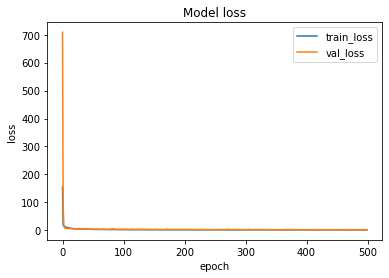

In [36]:
#plotting the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# 

# FACE DETECTION EXPRESSIONS:

In [37]:
# READING THE CSV FILE
df = pd.read_csv('icml_face_data.csv')
df.head()

emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3        2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...

# PERFORMING DATA WRANGING AND EDA

In [38]:
#function to convert pixel values in string format to array format

def string2array(x):
    return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [39]:
#Resize the image from (48,48) to (96,96)

def resize(x):
    img = x.reshape(48,48)
    return cv2.resize(img,dsize=(96, 96), interpolation=cv2.INTER_CUBIC)

In [40]:
df[' pixels'] = df[' pixels'].apply(lambda x: string2array(x))

In [41]:
df[' pixels'] = df[' pixels'].apply(lambda x: resize(x))

In [42]:
df.head()

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [43]:
#checking the shape of data_frame
df.shape

(24568, 2)

In [44]:
#checking for the presence of null values in the data frame
df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [45]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'smile', 4: 'surprise'}

### VISUALIZE THE DATASET

In [46]:
 df.emotion.value_counts().index

Int64Index([3, 2, 0, 4, 1], dtype='int64')

In [47]:
df.emotion.value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

Text(0.5, 1.0, 'Number of images per emotion')

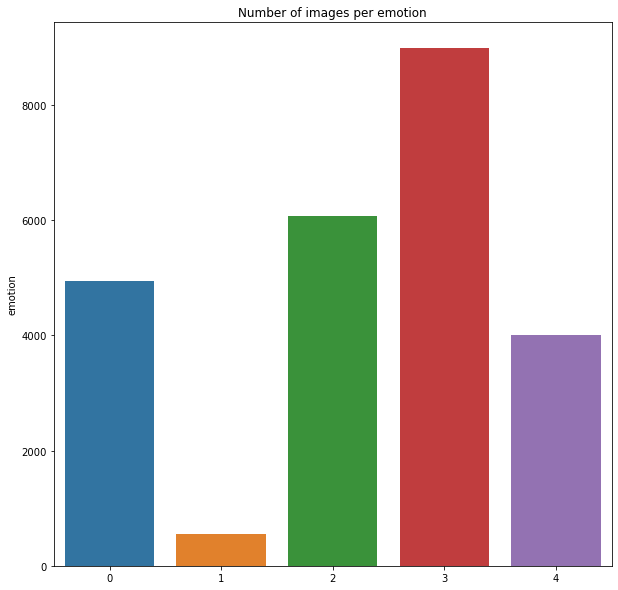

In [48]:
plt.figure(figsize=(10,10))
sns.barplot(x = df.emotion.value_counts().index, y = df.emotion.value_counts() )
plt.title('Number of images per emotion')

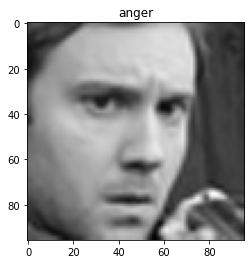

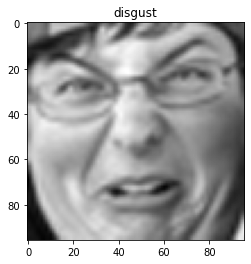

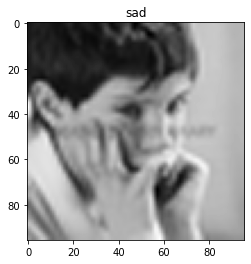

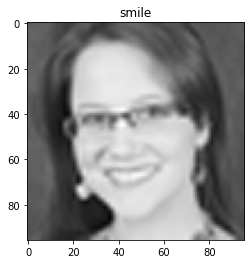

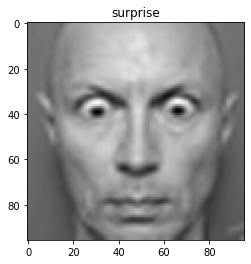

In [49]:
emotions = [0,1,2,3,4]

for i in emotions:
    data = df[df['emotion'] == i][:1]
    img = data[' pixels'].item()
    img = img.reshape(96,96)
    plt.figure()
    plt.title(label_to_text[i])
    plt.imshow(img, cmap= 'gray')

## DATA PREPARATION AD IMAGE AUGMENTATION

In [50]:
#spliting the dataframe in to features and labels
from keras.utils import to_categorical

x = df[' pixels']
y = to_categorical(df['emotion'])

x = np.stack(x, axis=0)
x = x.reshape(24568,96,96,1)

print(x.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [51]:
#spliting the dataframe in to train,test and validation data frames

x_train ,x_Test, y_train, y_Test= train_test_split(x,y,test_size = 0.1, shuffle = True)
x_val,x_Test, y_val,y_Test = train_test_split(x_Test,y_Test, test_size = 0.5, shuffle = True)

In [52]:
print(x_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [53]:
#image pre-processing
x_train = x_train/255
x_val   = x_val /255
x_Test  = x_Test/255

In [54]:
train_datagen = ImageDataGenerator(
rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode = "nearest"
)

# BUILDING AND TRAINING DEEP LEARNING MODEL

In [55]:
input_shape = (96,96,1)

#Input tensor shape
x_input = Input(input_shape)

#Zero-padding

x = ZeroPadding2D((3,3))(x_input)

# 1 - stage

x = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(x)
x = BatchNormalization(axis =3, name = 'bn_conv1')(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3), strides= (2,2))(x)

# 2- stage

x = res_block(x, filter= [64,64,256], stage= 2)

# 3- stage

x = res_block(x, filter= [128,128,512], stage= 3)

# 4- stage

#x = res_block(x, filter= [256,256,1024], stage= 4)



#Average Pooling

x = AveragePooling2D((4,4), name = 'Averagea_Pooling')(x)

#Final layer

x = Flatten()(x)
x = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(x)

In [56]:
model_e = Model( inputs= x_input, outputs = x, name = 'Resnet18')

model_e.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [57]:
# train the network
model_e.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [58]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights_emotions.hdf5", verbose=1, save_best_only=True)

In [59]:
history = model_e.fit(train_datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_val, y_val), steps_per_epoch=len(x_train) // 64,
    epochs= 500, callbacks=[checkpointer, earlystopping])

Epoch 1/500
345/345 [==============================] - 662s 2s/step - loss: 1.5231 - accuracy: 0.4080 - val_loss: 1.9572 - val_accuracy: 0.3998

Epoch 00001: val_loss improved from inf to 1.95715, saving model to weights_emotions.hdf5
Epoch 2/500
345/345 [==============================] - 664s 2s/step - loss: 0.9204 - accuracy: 0.6336 - val_loss: 1.2011 - val_accuracy: 0.4967

Epoch 00002: val_loss improved from 1.95715 to 1.20109, saving model to weights_emotions.hdf5
Epoch 3/500
345/345 [==============================] - 658s 2s/step - loss: 0.8185 - accuracy: 0.6805 - val_loss: 1.1607 - val_accuracy: 0.5252

Epoch 00003: val_loss improved from 1.20109 to 1.16074, saving model to weights_emotions.hdf5
Epoch 4/500
345/345 [==============================] - 668s 2s/step - loss: 0.7571 - accuracy: 0.7077 - val_loss: 0.8708 - val_accuracy: 0.6515

Epoch 00004: val_loss improved from 1.16074 to 0.87077, saving model to weights_emotions.hdf5
Epoch 5/500
345/345 [===========================


Epoch 00039: val_loss did not improve from 0.57400
Epoch 40/500
345/345 [==============================] - 713s 2s/step - loss: 0.3659 - accuracy: 0.8596 - val_loss: 0.7891 - val_accuracy: 0.6954

Epoch 00040: val_loss did not improve from 0.57400
Epoch 41/500
345/345 [==============================] - 575s 2s/step - loss: 0.3575 - accuracy: 0.8627 - val_loss: 0.6521 - val_accuracy: 0.7427

Epoch 00041: val_loss did not improve from 0.57400
Epoch 42/500
345/345 [==============================] - 652s 2s/step - loss: 0.3516 - accuracy: 0.8631 - val_loss: 0.7125 - val_accuracy: 0.7443

Epoch 00042: val_loss did not improve from 0.57400
Epoch 43/500
345/345 [==============================] - 529s 2s/step - loss: 0.3477 - accuracy: 0.8653 - val_loss: 0.6250 - val_accuracy: 0.7907

Epoch 00043: val_loss did not improve from 0.57400
Epoch 44/500
345/345 [==============================] - 534s 2s/step - loss: 0.3392 - accuracy: 0.8742 - val_loss: 0.6533 - val_accuracy: 0.7777

Epoch 00044: v

In [60]:
#saving the model architecture to json file for future use

model_json = model_e.to_json()
with open("emotion.json","w") as json_file:
    json_file.write(model_json)

# ACCESS PERFORMANCE OF THE MODEL

In [61]:
score = model_e.evaluate(x_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 13s 183ms/step - loss: 0.6680 - accuracy: 0.7754
Test Accuracy: 0.7754271626472473


In [62]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [63]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

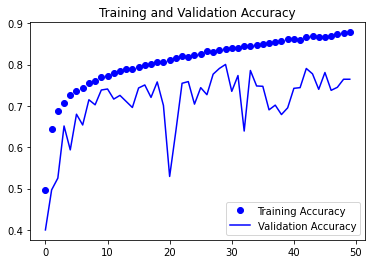

In [64]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

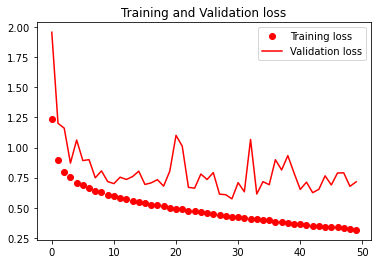

In [65]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [66]:
#predicted_classes = model.predict_classes(x_test)
predicted_classes = np.argmax(model_e.predict(x_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

In [67]:
y_true.shape

(1229,)

<AxesSubplot:>

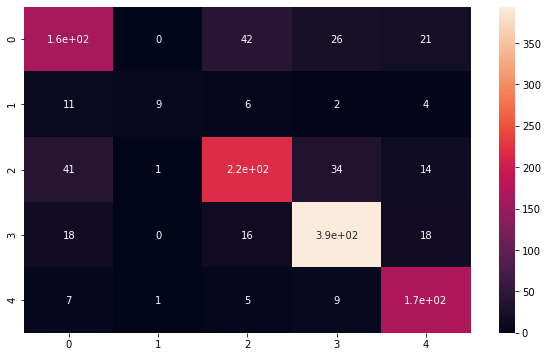

In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 6))
sns.heatmap(cm, annot = True)

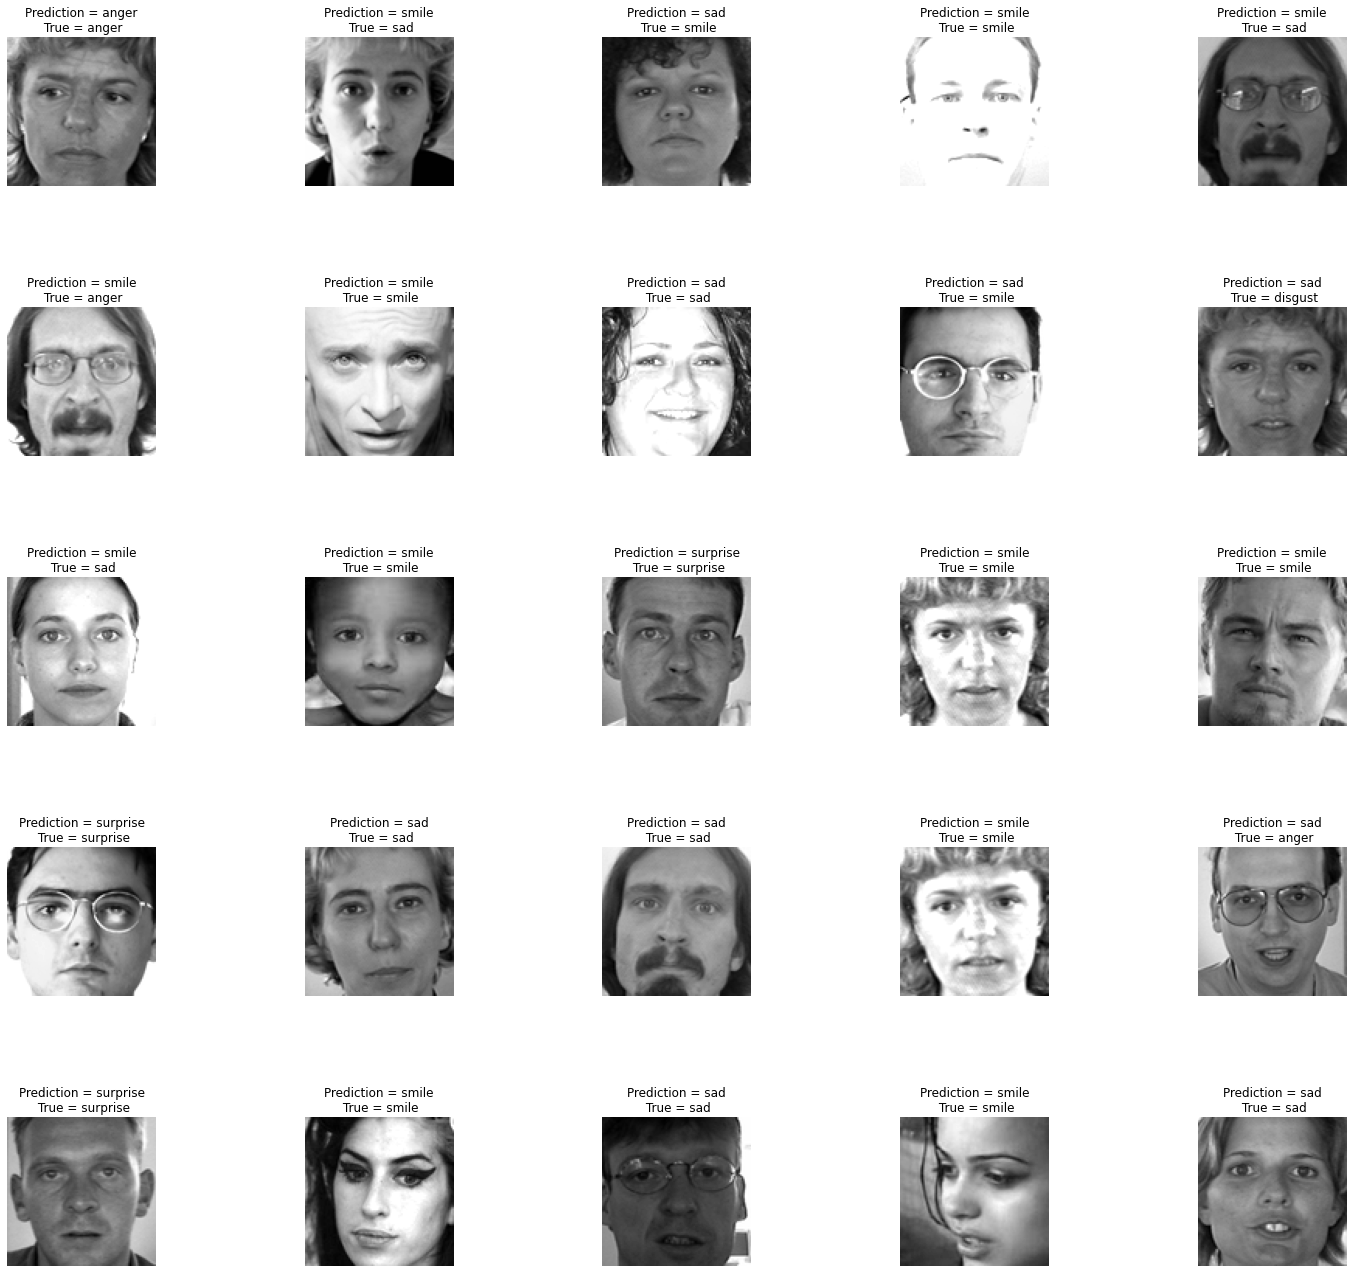

In [69]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(x_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)    

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.68      0.65      0.66       252
           1       0.82      0.28      0.42        32
           2       0.76      0.71      0.73       309
           3       0.85      0.88      0.86       446
           4       0.75      0.88      0.81       190

    accuracy                           0.78      1229
   macro avg       0.77      0.68      0.70      1229
weighted avg       0.77      0.78      0.77      1229



## COMBINING OUTPUTS OF FACIAL KEY POINTS DETECTION AND FACIAL EXPRESSION MODELS

In [71]:
def predict(x_test):

    #Making prediction from the keypoint model
    df_predict = model.predict(x_test)

    #Making prediction from the emotion model
    df_emotion = np.argmax(model_e.predict(x_test), axis=-1)

     #Reshaping array from (856,) to (856,1)
    df_emotion = np.expand_dims(df_emotion, axis = 1)
  
    #Converting the predictions into a dataframe
    df_predict= pd.DataFrame(df_predict, columns= columns)

    #Adding emotion into the predicted dataframe
    df_predict['emotion'] = df_emotion

    return df_predict

In [72]:
df_predict = predict(x_test)

In [73]:
df_predict.head()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          67.430634          37.235794           27.350342   
1          64.042862          34.131348           30.183937   
2          64.943886          34.254608           29.464531   
3          66.111160          38.558578           30.799561   
4          65.899513          37.308594           30.838295   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           37.603134                60.877872                37.748978   
1           34.230831                58.880177                34.752464   
2           35.235580                58.557728                34.983849   
3           39.378876                59.076767                39.701366   
4           37.635391                60.128387                38.041382   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.652817                37.813622                 33.709354   
1                69.528748                34.749687                 35.877625   
2                70.758347                34.786575                 35.493130   
3                72.746925                39.497963                 37.087559   
4                72.078972                37.914566                 36.593235   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 37.634762  ...   55.054344            63.113178   
1                 34.793297  ...   54.315384            58.498127   
2                 35.190563  ...   44.385635            63.137890   
3                 40.031361  ...   54.830929            63.145935   
4                 38.174976  ...   53.489990            62.015224   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            75.961845             34.275677             76.748383   
1            74.077827             37.018890             74.243172   
2            67.302231             32.699383             68.737419   
3            78.687164             33.370472             78.990898   
4            75.616837             32.527245             75.387283   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               48.659473               71.140404                  48.954067   
1               48.098282               68.168282                  48.005615   
2               47.505554               60.606789                  48.071583   
3               46.970554               73.457848                  47.326622   
4               46.278236               69.829956                  46.337452   

   mouth_center_bottom_lip_y  emotion  
0                  84.661194        2  
1                  82.653793        4  
2                  70.843781        2  
3                  83.287636        3  
4                  82.148216        4  

[5 rows x 31 columns]

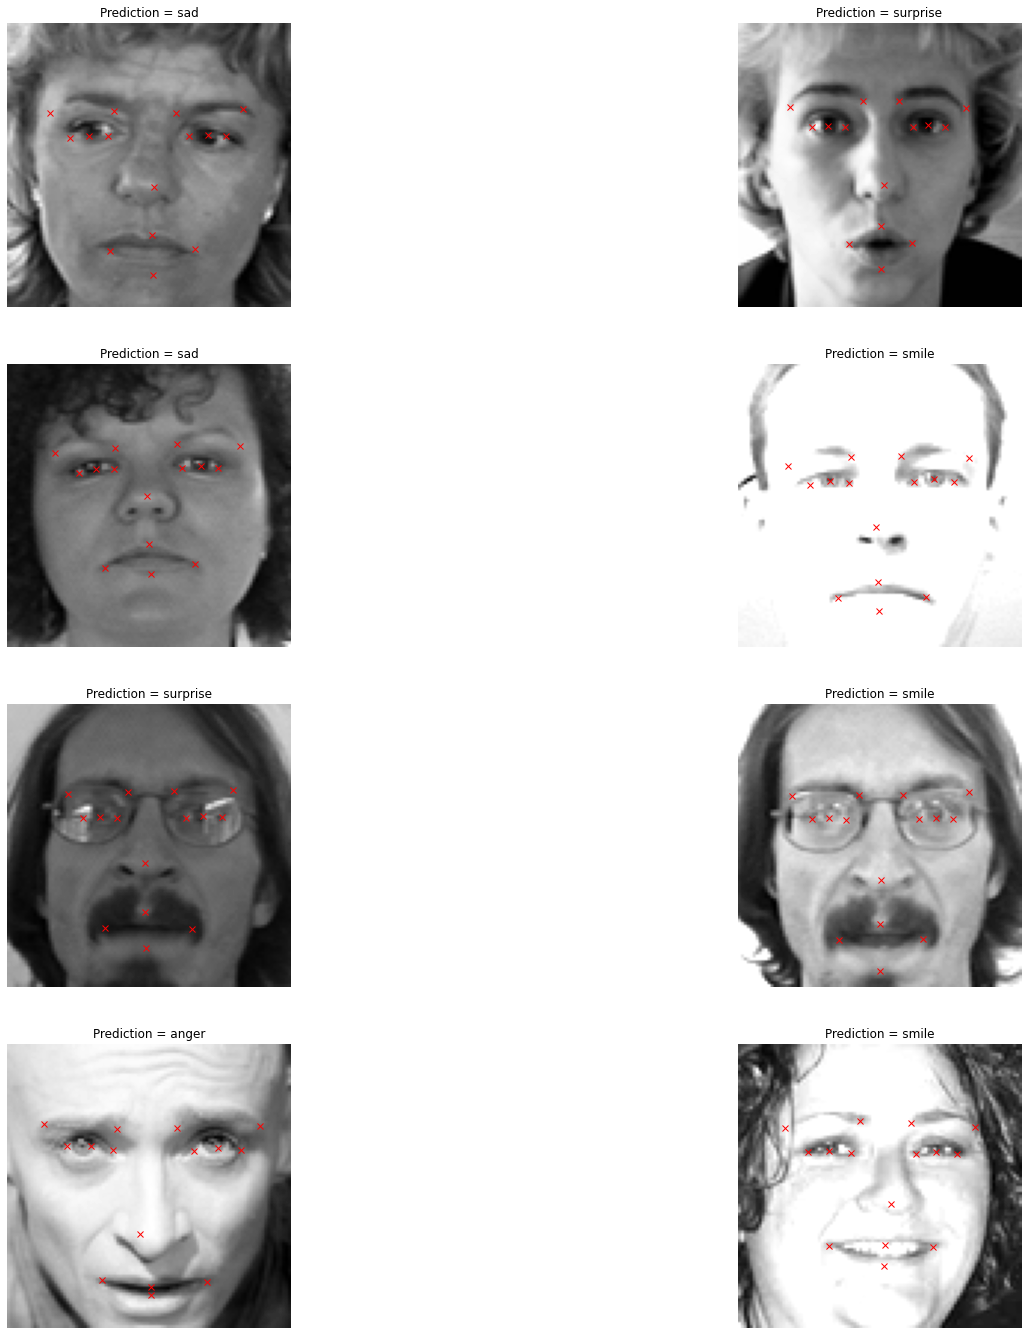

In [74]:
#Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(4, 2, figsize = (24, 24))
axes = axes.ravel()

for i in range(8):

    axes[i].imshow(x_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
            

# Grad-CAM: (Gradient-weighted Class Activation Mapping) Visualization

In [75]:
from PIL import Image, ImageOps

def grad_cam(img):

    #Covert the image to array of type float32
    img = np.asarray(img, dtype= np.float32)

     #Reshape the image from (96,96,1) to (1,96,96,1))
    img = img.reshape(-1,96,96,1)
    img_scaled = img / 255

    #Name of the layers we added to the base_model, you can find this in the model summary
    #Every-time you run the model, check the summary, as the name would change or to avoid it 
    #you can add name to each layer
    classification_layers = ["Averagea_Pooling","Dense_final"]

    #Last convolutional layer in the base mdel, this woun't change as name has been already assigned to it.
    final_conv = model_e.get_layer("res_3_identity_2_c")

    #Create a model with original model input as input and the last conv_layer as the output
    final_conv_model = keras.Model(model_e.inputs, final_conv.output)

    #Then,we create the input for classification layer, which is the output of last conv layer
    #In our case, output produced by the conv layer is of the shape (1,2,2,1024) 
    #Since, the classification input needs the features as input, we ignore the batch dimension

    classification_input = keras.Input(shape=final_conv.output.shape[1:])

    # We iterate through the classification layers, to get the final layer and then, append 
    #the layer as the output layer to the classification model.
    temp = classification_input
    for layer in classification_layers:
        temp = model_e.get_layer(layer)(temp)
    classification_model = keras.Model(classification_input, temp)


    #We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
    #corresponding to the predicted class
    with tf.GradientTape() as tape:
        # Pass the image through the base model and get the feature map 
        final_conv_output = final_conv_model(img_scaled)

        #Assign gradient tape to monitor the conv_output
        tape.watch(final_conv_output)
      
      #Pass the feature map through the classification model and use argmax to get the 
      #index of the predicted class and then use the index to get the value produced by final
      #layer for that class

        prediction = classification_model(final_conv_output)

        predicted_class = tf.argmax(prediction[0][0][0])

        predicted_class_value = prediction[:,:,:,predicted_class]

  #Get the gradient corresponding to the predicted class based on feature map.
  #which is of shape (1,2,2,1024)
    gradient = tape.gradient(predicted_class_value, final_conv_output)

  #Since we need the filter values (1024), we reduce the other dimensions, 
  #hich would result in a shape of (1024,)
    gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

  #We then convert the feature map produced by last conv layer(1,2,2,1024) to (1,2,2,1024)

    final_conv_output = final_conv_output.numpy()[0]
 
    gradient_channels = gradient_channels.numpy()

  #We multiply the filters in the feature map produced by final conv layer by the 
  #filter values that are used to get the predicted class. By doing this we inrease the
  #value of areas that helped in making the prediction and lower the vlaue of areas, that 
  #did not contribute towards the final prediction
    for i in range(gradient_channels.shape[-1]):
        final_conv_output[:, :, i] *= gradient_channels[i]

  #We take the mean accross the channels to get the feature map
    heatmap = np.mean(final_conv_output, axis=-1)

  #Normalizing the heat map between 0 and 1, to visualize it
    heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

  # Rescaling and converting the type to int
    heatmap = np.uint8(255 * heatmap_normalized )


  # Create the colormap
    color_map = plt.cm.get_cmap('jet')

  # get only the rb features from the heatmap
    color_map = color_map(np.arange(256))[:, :3]
    heatmap = color_map[heatmap]

   #convert the array to image, resize the image and then convert to array
    heatmap = keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((96 ,96))
    heatmap = np.asarray(heatmap, dtype = np.float32)

  #take the value of heat map along any one channel as or image is of 1 channel
    heatmap = heatmap[:,:,2]
    heatmap = np.expand_dims(heatmap, axis = 2) 
 
    final_img =  (img[0]*0.4) + ((heatmap/255.0) * 0.8)
    final_img = keras.preprocessing.image.array_to_img(final_img)
  
    return final_img, heatmap_normalized

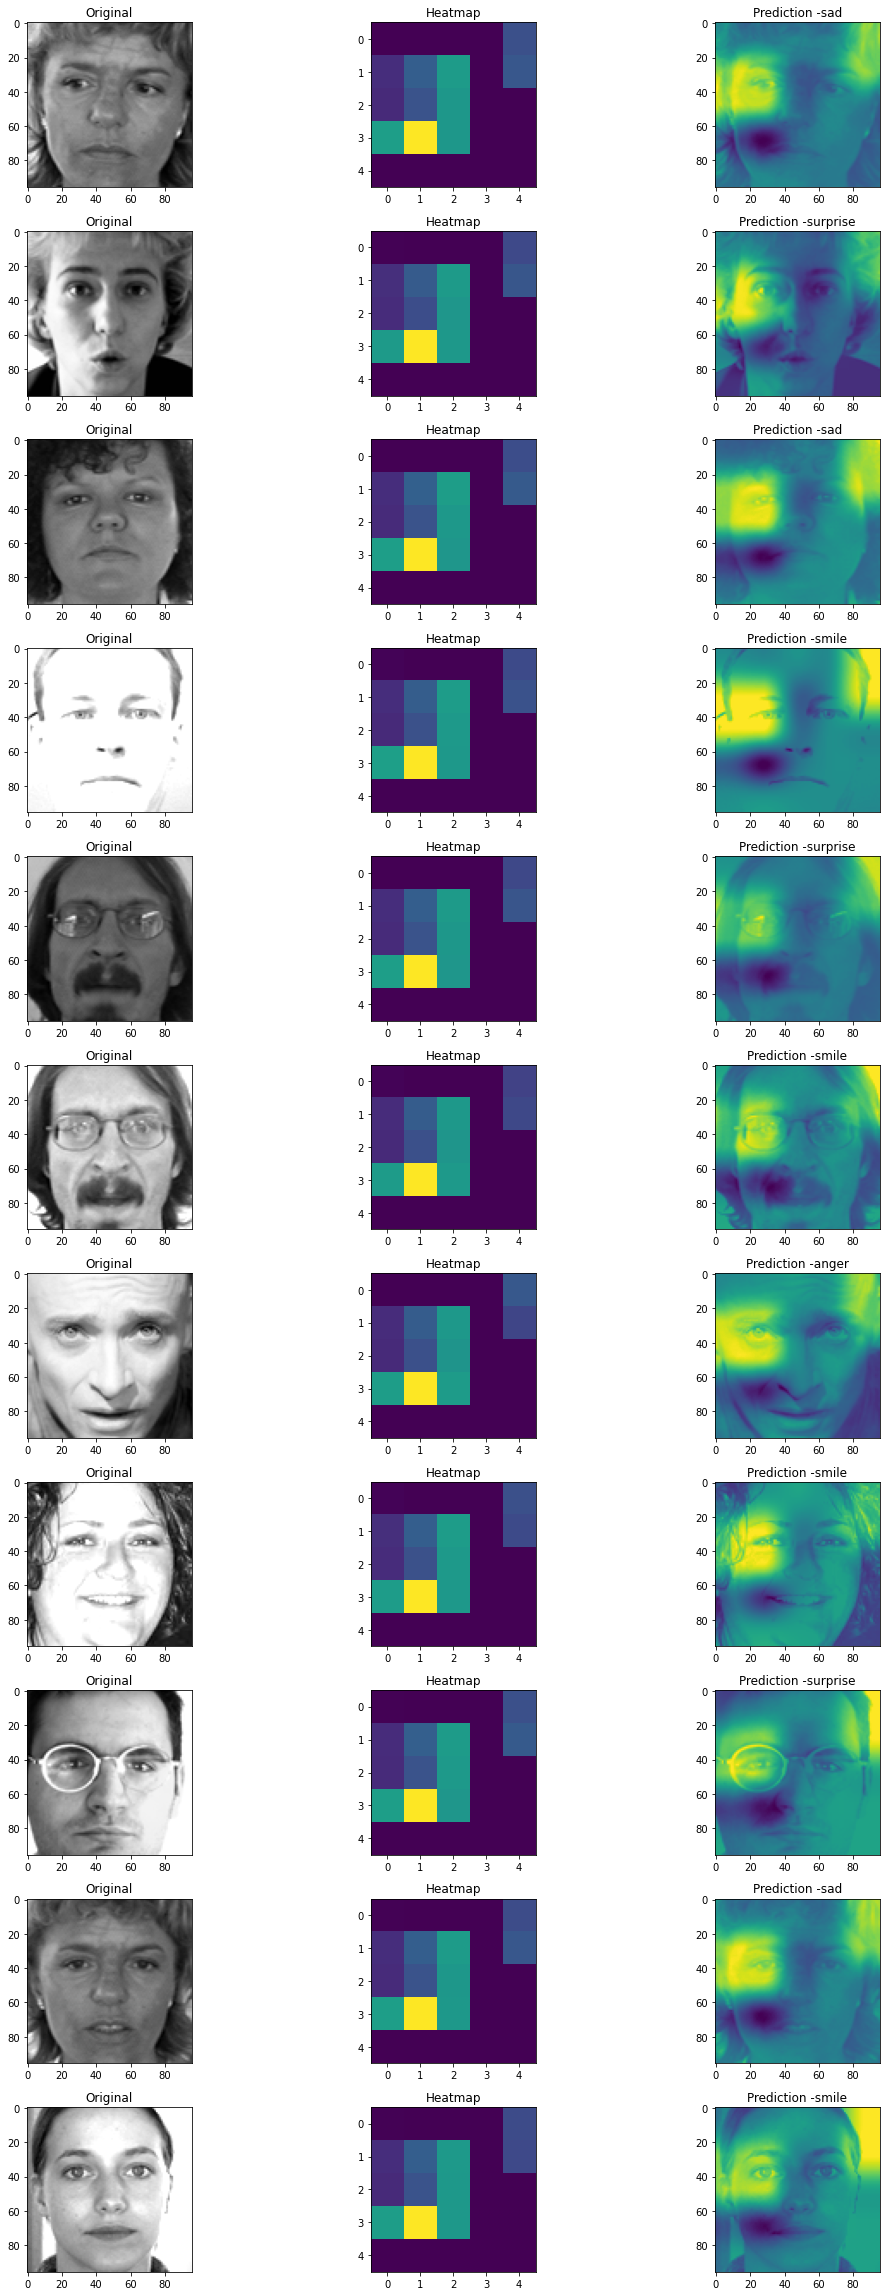

In [76]:
#Visualize the images in the dataset
import random
fig, axs = plt.subplots(11,3, figsize=(16,32))
count = 0
for i in range(11):
  #i = random.randint(0,len(X_test))
    gradcam, heatmap = grad_cam(x_test[i])
    axs[count][0].title.set_text("Original")
    axs[count][0].imshow(x_test[i].squeeze(),cmap = 'gray')
    axs[count][1].title.set_text("Heatmap") 
    axs[count][1].imshow(heatmap)
    axs[count][2].title.set_text("Prediction -" + label_to_text[df_predict['emotion'][i]]) 
    axs[count][2].imshow(gradcam)  
    count += 1

fig.tight_layout()